In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from torch.linalg import inv

torch.backends.cudnn.deterministic=True
torch.cuda.manual_seed(0)
torch.random.manual_seed(0)
torch.manual_seed(0)
np.random.seed(0) 

from math import sqrt, pi

import rfm

import ntk
import kernels

import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

`eigenpro2` is not installed...
Using `torch.linalg.solve` for training the kernel model

          and may cause an `Out-of-Memory` error
`eigenpro2` is a more scalable solver. To use, pass `method="eigenpro"` to `model.fit()`
To install `eigenpro2` visit https://github.com/EigenPro/EigenPro-pytorch/tree/pytorch/
Importing


In [3]:
## variables
os.environ['DATA_PATH'] = "/scratch/bbjr/dbeaglehole/"
dataset = 'cifar'

In [4]:
def mat_cov(A, B):
    A_ = A.reshape(-1).clone() 
    B_ = B.reshape(-1).clone()
    
    # A_ -= A_.mean()
    # B_ -= B_.mean()
    
    norm1 = A_.norm()
    norm2 = B_.norm()
    
    return (torch.dot(A_, B_) / norm1 / norm2).item()

def scale2(A):
    Ab = A - A.mean()
    return Ab / Ab.diag().mean()

def scale(A):
    return (A - A.min())/(A.max() - A.min())
    # return A / A.mean()
    # return A
    
def one_hot_data(dataset, num_classes, num_samples):
    Xs = []
    ys = []

    for ix in range(min(len(dataset),num_samples)):
        X,y = dataset[ix]
        Xs.append(X)

        ohe_y = torch.zeros(num_classes)
        ohe_y[y] = 1
        ys.append(ohe_y)

    return torch.stack(Xs), torch.stack(ys)

def get_binary(dataset, classes):
    c1, c2 = classes
    
    binary_dataset = []
    for ix in tqdm(range(len(dataset))):
        X,y = dataset[ix]
        
        if y==c1:
            binary_dataset.append((X,0))
        elif y==c2:
            binary_dataset.append((X,1))

    return binary_dataset

if dataset=='mnist':
    transform = transforms.Compose(
        [
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "MNIST/"
    trainset = torchvision.datasets.MNIST(root=path,
                                        train = True,
                                        transform=transform,
                                        download=True)
    testset = torchvision.datasets.MNIST(root=path,
                                        train = False,
                                        transform=transform,
                                        download=True)
elif dataset=='cifar':
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "cifar10/"

    trainset = torchvision.datasets.CIFAR10(root=path,
                                            train=True,
                                            transform=transform,
                                            download=True)
    testset = torchvision.datasets.CIFAR10(root=path,
                                           train=False,
                                           transform=transform,
                                           download=True)

NUM_CLASSES = 10

# NUM_CLASSES = 2
# class1 = 3
# class2 = 5
# trainset = get_binary(trainset, classes=(class1, class2))
# testset = get_binary(testset, classes=(class1, class2))

n=500
train_X, train_y = one_hot_data(trainset, NUM_CLASSES, num_samples=n)
test_X, test_y = one_hot_data(testset, NUM_CLASSES, num_samples=n)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_X = train_X.cuda()
train_y = train_y.cuda()
test_X = test_X.cuda()
test_y = test_y.cuda()

In [6]:
## reorder data
newXs = []
newYs = []
for c in range(NUM_CLASSES):
    class1_idx = train_y[:,c] == 1
    newYs.append(train_y[class1_idx])
    newXs.append(train_X[class1_idx])

train_X = torch.concat(newXs,dim=0)
train_y = torch.concat(newYs,dim=0)
print(train_X.shape, train_y.shape)

torch.Size([500, 3, 32, 32]) torch.Size([500, 10])


In [7]:
## -1,+1 labels
train_y -= 0.5
train_y *= 2

test_y -= 0.5
test_y *= 2

In [8]:
def matrix_sqrt(M):
    S, V = torch.linalg.eigh(M)
    S[S<0] = 0
    S = torch.diag(S**0.5)
    return V @ S @ V.T
    
class Activation(nn.Module):
    def __init__(self):
        super(Activation, self).__init__()
    def forward(self, x):
        return nn.ReLU()(x)# - sqrt(2*pi)**-1
    
def sample_feats(M, d, k):
    weight_fn = nn.Linear(d, k, bias=False).to(M.device).to(M.dtype)
    weight_fn.weight = nn.Parameter(weight_fn.weight@M, requires_grad=False)
    return nn.Sequential(weight_fn, 
                      Activation()
                     )
    # return nn.Identity()

In [9]:
import utils 
import ntk
from functorch import jacrev, vmap

def get_grads(alphas, train_X, Xs, M, ntk_depth=1):
    
    M_is_passed = M is not None
    sqrtM = None
    if M_is_passed:
        sqrtM = utils.matrix_sqrt(M)
    
    def get_solo_grads(sol, X, x):
        if M_is_passed:
            X_M = X@sqrtM
        else:
            X_M = X
            
        def egop_fn(z):
            if M_is_passed:
                z_ = z@sqrtM
            else:
                z_ = z
            K = ntk.ntk_relu(z_, X_M, M=None, depth=ntk_depth)[1]
            return (K@sol).squeeze()
        grads = vmap(jacrev(egop_fn))(x.unsqueeze(1)).squeeze()
        grads = torch.nan_to_num(grads)
        return grads 

    n, d = train_X.shape
    s = len(Xs)
    
    chunk = 1000
    train_batches = torch.split(torch.arange(n), chunk)

    egop = 0
    G = 0
    for btrain in train_batches:
        G += get_solo_grads(alphas[btrain,:], train_X[btrain], Xs)
    G = G.reshape(-1, d)
    egop += G.T @ G/s

    return egop


def get_poly_grads(alphas, train_X, Xs, M, power, L):
    
    M_is_passed = M is not None
    sqrtM = None
    if M_is_passed:
        sqrtM = utils.matrix_sqrt(M)
    
    def get_solo_grads(sol, X, x):
        if M_is_passed:
            X_M = X@sqrtM
        else:
            X_M = X
            
        def egop_fn(z):
            if M_is_passed:
                z_ = z@sqrtM
            else:
                z_ = z
            # print("z_",z_.shape, "X_M", X_M.shape)
            K = torch.pow(z_@X_M.T / L, power)
            return (K@sol).squeeze()
        grads = vmap(jacrev(egop_fn))(x.unsqueeze(1)).squeeze()
        grads = torch.nan_to_num(grads)
        return grads 

    n, d = train_X.shape
    s = len(Xs)
    
    chunk = 1000
    train_batches = torch.split(torch.arange(n), chunk)

    egop = 0
    G = 0
    for btrain in train_batches:
        G += get_solo_grads(alphas[btrain,:], train_X[btrain], Xs)
    G = G.reshape(-1, d)
    egop += G.T @ G/s

    return egop

In [10]:
def get_GK(Xs, train_X, M, kernel='ntk', ntk_depth=2):
    M_is_passed = M is not None
    sqrtM = None
    if M_is_passed:
        sqrtM = utils.matrix_sqrt(M)
        
    def get_solo_grads(X, x):
        if M_is_passed:
            X_M = X@sqrtM
        else:
            X_M = X
            
        def kernel_fn(z):
            if M_is_passed:
                z_ = z@sqrtM
            else:
                z_ = z
            K = ntk.ntk_relu(z_, X_M, M=None, depth=ntk_depth)[1]
            return K
        
        grads = vmap(jacrev(kernel_fn))(x.unsqueeze(1)).squeeze()
        grads = torch.nan_to_num(grads)
        return grads 
    
    n, d = train_X.shape
    s = len(Xs)
    
    chunk = 250
    train_batches = torch.split(torch.arange(n), chunk)

    GK = 0
    for btrain in train_batches:
        b = len(btrain)
        G = get_solo_grads(train_X[btrain], Xs).transpose(0,1) # (b, n, d)
        G = G.reshape(n, b*d)
        GK += G@G.T
    GK /= s

    return GK

In [11]:
def ntk_rfm(train_X, train_y, test_X, test_y, iters, reg, ntk_depth, center_kernel, agop_reg):
    n, d = train_X.shape
    M = None
    K = None
    for t in range(iters):
        Ktrain = ntk.ntk_relu(train_X, depth=ntk_depth, M=M)[1]
        Ktest = ntk.ntk_relu(test_X, train_X, depth=ntk_depth, M=M)[1]
        
        if center_kernel:
            # print("Centering kernels")
            # a = torch.zeros((1,d)).to(train_X.device)
            # b = torch.zeros((1,d)).to(train_X.device)
            # a[0,0] = 1
            # b[0,1] = 1     
            # alpha = ntk.ntk_relu(a,b,depth=ntk_depth)[1].item()
            # alpha /= 1
            S, U = torch.linalg.eigh(Ktrain)
            alpha = torch.max(S/len(Ktrain))
            Ktrain += alpha*torch.ones(Ktrain.shape).to(Ktrain.device)
            Ktest += alpha*torch.ones(Ktest.shape).to(Ktest.device)
            
        scale = Ktrain.max()
        Ktrain /= scale
        Ktest /= scale
        
        if t==0:
            K = Ktrain.cpu()
        
        if agop_reg:
            s = len(train_X)
            GK = get_GK(train_X[:s], train_X, M, kernel='ntk', ntk_depth=ntk_depth).double()
            GK /= GK.max()
            
            Ktraind = Ktrain.double()
            train_yd = train_y.double()
            # + reg*torch.eye(n).to(Ktrain.device)).double()
            alphas = inv(Ktraind@Ktraind + reg*GK)@ Ktraind @ train_yd
            alphas = alphas.float()
        else:
            alphas = torch.linalg.solve(reg*torch.eye(n).to(Ktrain.device) + Ktrain, train_y)
        ypred = Ktest@alphas
        
        acc = torch.mean(1.0*(torch.argmax(ypred,dim=1) == torch.argmax(test_y,dim=1))) * 100
        mse = torch.mean(torch.sum((ypred - test_y)**2,axis=1))
        
        print(f'Round {t} accuracy: {acc}%')
        print(f'Round {t} MSE: {mse}')
        print()
            
        M = get_grads(alphas, train_X, train_X, M)
        
    return M, K

In [12]:
def poly_rfm(train_X, train_y, test_X, test_y, iters, reg, L, power=2):
    n, d = train_X.shape
    M = torch.eye(d).to(train_X.device).to(train_X.dtype)
    K = None
    for t in range(iters):
        print(f't is {t}')
        Ktrain = torch.pow(train_X@M@train_X.T / L, power)
        Ktest = torch.pow(test_X@M@train_X.T / L, power)
        
        scale = Ktrain.max()
        Ktrain /= scale
        Ktest /= scale
        
        a = 0.
        Ktrain += a
        Ktest += a
        
        b = 0.01
        Ktrain += b*torch.eye(n).to(Ktrain.dtype).to(Ktrain.device)
        
        if t==0:
            K = Ktrain.cpu()
        
        alphas = torch.linalg.solve(reg*torch.eye(n).to(Ktrain.device).to(train_X.dtype) + Ktrain, train_y)
        ypred = Ktest@alphas
        
        acc = torch.mean(1.0*(torch.argmax(ypred,dim=1) == torch.argmax(test_y,dim=1))) * 100
        mse = torch.mean(torch.sum((ypred - test_y)**2,axis=1))
        
        print(f'Round {t} accuracy: {acc}%')
        print(f'Round {t} MSE: {mse}')
        print()
            
        M = get_poly_grads(alphas, train_X, train_X, M, L=L, power=power)
        
    return M, K

In [33]:
%%capture

DEPTH = 6
ITERS = 1
WIDTH = 1024
# KERNEL='ntk'
# KERNEL='laplace'
KERNEL='gaussian'
# KERNEL='quadratic'
NTK_DEPTH=2
# BW = 2.0
BW = 4.0
REG = 0.#1e-10
AGOP_REG = False
EXP = 1

train_X_deep = train_X.reshape(len(train_X),-1)#.double()
test_X_deep = test_X.reshape(len(test_X),-1)#.double()
train_y = train_y.to(train_X_deep.dtype)
test_y = test_y.to(test_X_deep.dtype)


# XXs = [(train_X_deep@train_X_deep.T).cpu()]
Xs = []
Xts = []
XXs = []
Ks = []
Ms = []
Ktests = []
for dep in range(DEPTH):
    print(f'Depth {dep} of DeepRFM')
    
    
    train_X_deep /= train_X_deep.norm(dim=-1).unsqueeze(1)
    # train_X_deep -= train_X_deep.mean(dim=0).unsqueeze(0)
    
    test_X_deep /= test_X_deep.norm(dim=-1).unsqueeze(1)
    
    XX = (train_X_deep@train_X_deep.T).cpu()
    XXs.append(XX)
    
    Xs.append(train_X_deep)
    Xts.append(test_X_deep)
    
    # plt.imshow(XX)
    # plt.colorbar()
    # plt.savefig(f'figures/dataset_{dataset}_layer_{dep}_inner_product_matrix_deepRFM',format='pdf')
    # plt.close()
    
    if KERNEL == 'laplace':
        model = rfm.LaplaceRFM(bandwidth=BW, device="cuda")
        model.fit(
            (train_X_deep, train_y), 
            (test_X_deep, test_y), 
            loader=False, 
            iters=ITERS,
            classif=True,
            reg=REG
        )
        M = model.M
        K = kernels.laplacian(train_X_deep, train_X_deep, BW)
        
    if KERNEL == 'gaussian':
        model = rfm.GaussRFM(bandwidth=BW, device="cuda")
        model.fit(
            (train_X_deep, train_y), 
            (test_X_deep, test_y), 
            loader=False, 
            iters=ITERS,
            classif=True,
            reg=REG
        )
        M = model.M
        K = kernels.gaussian(train_X_deep, train_X_deep, BW)
        Ktest = kernels.gaussian(test_X_deep, train_X_deep, BW)
        
    elif KERNEL == 'ntk':
        M, K = ntk_rfm(
            train_X_deep, train_y, 
            test_X_deep, test_y,
            iters=ITERS,
            reg=REG,
            ntk_depth=NTK_DEPTH,
            center_kernel=False,
            agop_reg=AGOP_REG
        )
        
    elif KERNEL == 'quadratic':
        M, K = poly_rfm(
            train_X_deep, train_y, 
            test_X_deep, test_y,
            iters=ITERS,
            reg=REG,
            L=BW,
            power=EXP
        )
        
    # XX = (train_X_deep@M@train_X_deep.T).cpu()
    # XXs.append(XX)
        
    Ks.append(K.cpu())
    Ms.append(M.cpu())
    # Ktests.append(Ktest.cpu())
        
    _, d = train_X_deep.shape

    feature_fn = sample_feats(utils.matrix_sqrt(M, thresh=False), d, WIDTH).cuda()
    train_X_deep = feature_fn(train_X_deep)
    test_X_deep = feature_fn(test_X_deep)
    print('\n\n')

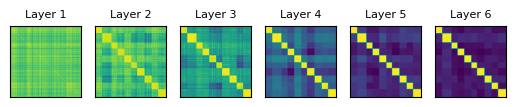

In [38]:
fig, axes = plt.subplots(1, DEPTH)

for idx in range(DEPTH):
    ax = axes[idx]
    XX = XXs[idx]
    ax.imshow(XX)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Layer {idx+1}', fontsize=8)
        
plt.savefig('figures/deep_rfm_cifar_example.pdf', format='pdf')

__pycache__/    figures/  kernels.py  ntk_scratch.ipynb  vis_nc.py
deep_rfm.ipynb  grads.py  ntk.py      utils.py


In [39]:
# PLOTS_PER_ROW=4
# NUM_ROWS = DEPTH//PLOTS_PER_ROW
# fig, axes = plt.subplots(NUM_ROWS, PLOTS_PER_ROW)

# for row in range(NUM_ROWS):
#     for col in range(PLOTS_PER_ROW):
#         ax = axes[row][col]
        
#         idx = int(row * PLOTS_PER_ROW) + col
#         XX = XXs[idx]
#         ax.imshow(XX)
#         ax.set_xticks([])
#         ax.set_yticks([])
        
# plt.savefig()

In [235]:
i=-1
M = matrix_sqrt(Ms[i].cuda())
X = Xs[i].cuda()

In [236]:
newXs = (X@M).cpu()
newXs -= newXs.mean(dim=0)
# newXs /= newXs.norm(dim=1).unsqueeze(1)

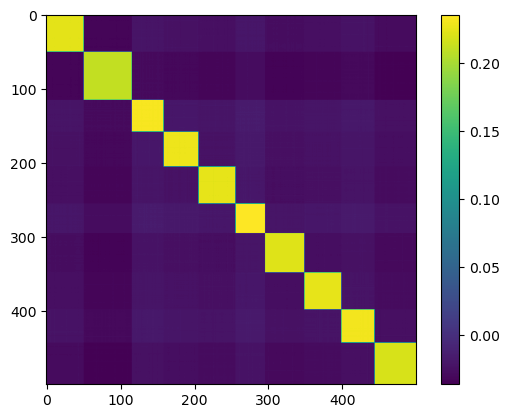

In [237]:
plt.imshow(newXs@newXs.T)
plt.colorbar()

In [227]:
from torch.linalg import inv
XXinvs = []
Kinvs = []

for dep in range(DEPTH):
    # XX = scale2(XXs[dep]).double()
    # K = scale2(Ks[dep]).double()
    XX = XXs[dep].double()
    K = Ks[dep].double()
    
    Kinv = inv(K)
    XXinv = inv(XX)
    
    XXinvs.append(XXinv)
    Kinvs.append(Kinv)
    
    print("mats", mat_cov(XX, K), "invs", mat_cov(XXinv, Kinv))

mats 0.9999998510439982 invs 0.8547606776775556
mats 0.9999998463287018 invs 0.461198765963601
mats 0.999999811322166 invs 0.09972374649170637
mats 0.9999998140837483 invs 0.04185725232786548
mats 0.999999799108458 invs -0.011741472043036046
mats 0.9999998135258203 invs 0.007701266115440366
mats 0.9999997959976563 invs -0.0034580800613000745
mats 0.9999998113417535 invs -0.019174897614829003
mats 0.999999804308927 invs 0.006716947708602099
mats 0.9999998119099603 invs 0.016488217504880654
mats 0.9999998089399655 invs -0.01971640240667515
mats 0.9999998115667105 invs -0.010798298041592835
mats 0.9999998156904294 invs 0.01280042455378231
mats 0.999999814242693 invs 0.01290691239360076
mats 0.9999997981174292 invs -0.007363645569852904
mats 0.9999998018653151 invs -0.001112511595995538


\lambda((XX) inv) 9.623857844808514 \lambda(K inv) 2.4398094626624522
\lambda((XX) inv) 21.994752873549032 \lambda(K inv) 1.206109720355478
\lambda((XX) inv) 219.09652143885646 \lambda(K inv) 1.0923713007237696
\lambda((XX) inv) 559.5438655274854 \lambda(K inv) 1.0478653705874335
\lambda((XX) inv) 1042.362587777163 \lambda(K inv) 1.0368505208367431
\lambda((XX) inv) 2140.8033299293847 \lambda(K inv) 1.0289333515490136


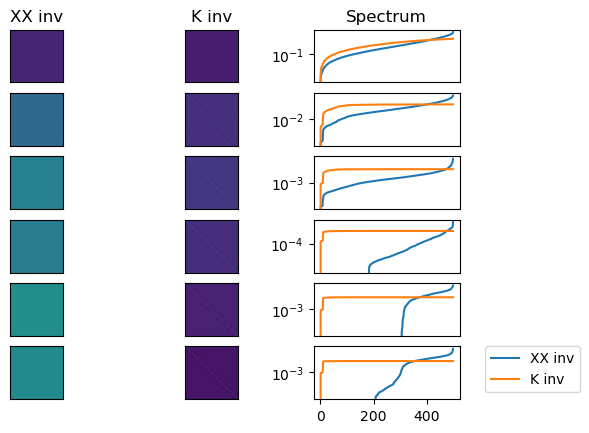

In [243]:
DEPTH_TO_PLOT=6
fig, axes = plt.subplots(DEPTH_TO_PLOT,3)

axes[0][0].set_title("XX inv")
axes[0][1].set_title("K inv")
axes[0][2].set_title("Spectrum")

for dep in range(DEPTH_TO_PLOT):
    axes_dep = axes[dep]
    XX=XXinvs[dep]
    K=Kinvs[dep]

    
    im1 = axes_dep[0].imshow(scale2(XX))
    im2 = axes_dep[1].imshow(scale2(K))
    
    axes_dep[0].set_xticks([])
    axes_dep[0].set_yticks([])
    axes_dep[1].set_xticks([])
    axes_dep[1].set_yticks([])
    
    
    S1, _ = torch.linalg.eigh(scale2(XX.cuda()))
    S2, _ = torch.linalg.eigh(scale2(K.cuda()))
    axes_dep[2].semilogy(S1.cpu(), label='XX inv')
    axes_dep[2].semilogy(S2.cpu(), label='K inv')
    
    print('\lambda((XX) inv)', torch.max(S1).item(), '\lambda(K inv)', torch.max(S2).item())
    
    if dep != DEPTH_TO_PLOT-1:
        axes_dep[2].set_xticks([])
    

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.5,0))

In [27]:
# i = 0

# train_X_ = Xs[i].double().cpu()
# test_X_ = Xts[i].double().cpu()

# train_y_ = train_y.cpu().double()

# XX = (train_X_@train_X_.T)
# XXinv = inv(XX)

# xX = test_X_@train_X_.T
# alin = XXinv@train_y_
# ylinear_preds = xX@alin

In [28]:
# KK = Ks[i].cpu().double()
# kK = Ktests[i].cpu().double()

# c = KK.mean()
# d = KK.diag().mean()
# KK -= c
# KK /= d

# kK -= c
# kK /= d

# Kinv = inv(KK)
# akern = Kinv@train_y_

# ykernel_preds = kK@akern

In [29]:
# mat_cov(scale2(ykernel_preds), scale2(ylinear_preds))

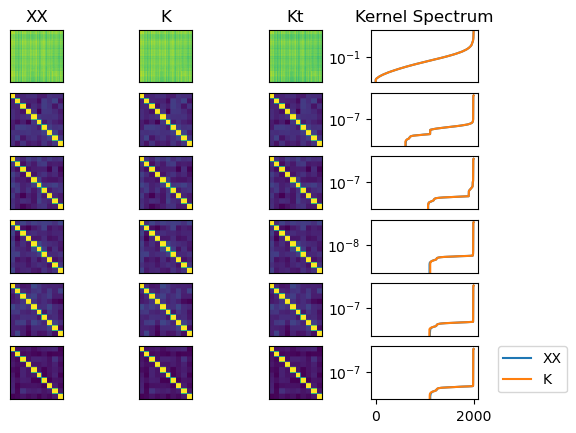

In [66]:
DEPTH_TO_PLOT=6
fig, axes = plt.subplots(DEPTH_TO_PLOT,4)

axes[0][0].set_title("XX")
axes[0][1].set_title("K")
axes[0][2].set_title("Kt")
axes[0][3].set_title("Kernel Spectrum")
# axes[0][3].set_title("M Spectrum")

for dep in range(DEPTH_TO_PLOT):
    axes_dep = axes[dep]
    XX = XXs[dep].clone()
    # XX /= XX.trace()
    
    K = Ks[dep].clone()
    # K /= K.trace()
    
    Kt = 1 - 1/BW + XX/BW + (XX - 1)**2 / (2 * BW**2)
    
    
    im1 = axes_dep[0].imshow(scale2(XX))
    im2 = axes_dep[1].imshow(scale2(K))
    im3 = axes_dep[2].imshow(scale2(Kt))
    
    axes_dep[0].set_xticks([])
    axes_dep[0].set_yticks([])
    axes_dep[1].set_xticks([])
    axes_dep[1].set_yticks([])
    axes_dep[2].set_xticks([])
    axes_dep[2].set_yticks([])
    
    
    
    S1, _ = torch.linalg.eigh(scale2(XX.cuda()))
    S2, _ = torch.linalg.eigh(scale2(K.cuda()))
    # S3, _ = torch.linalg.eigh(Kt.cuda())
    
    axes_dep[3].semilogy(S1.cpu(), label='XX')
    axes_dep[3].semilogy(S2.cpu(), label='K')
    # axes_dep[3].semilogy(S3.cpu(), label='Kt')
    
    if dep != DEPTH_TO_PLOT-1:
        axes_dep[3].set_xticks([])
    
    
    # plt.colorbar(im1)
    # plt.colorbar(im2)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.5,0))

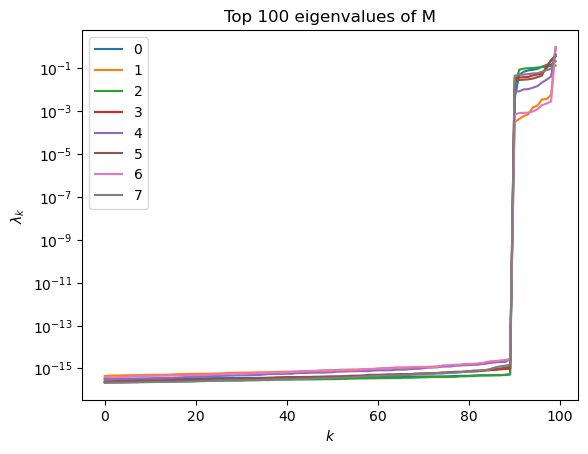

In [67]:
fig, ax = plt.subplots(1,1)

for dep in range(DEPTH):
    S3, _ = torch.linalg.eigh(Ms[dep].cuda())
    S3 /= S3.sum()
    ax.semilogy(S3.cpu()[-100:], label=f'{dep}')
    
ax.legend()
ax.set_title('Top 100 eigenvalues of M')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\lambda_k$')
plt.show()

In [48]:
# 1. use kernel entires as feature map for next layer

In [49]:
def get_effective_rank(S_, k=400):
    S = S_[:k]
    ell1 = S.abs().sum()
    ell2 = S.norm()
    return (ell1/ell2)**2 / len(S)
    
eff_ranks = []
for dep in range(DEPTH):
    S2, _ = torch.linalg.eigh(XXs[dep].cuda())
    eff_ranks.append(get_effective_rank(S2).cpu())

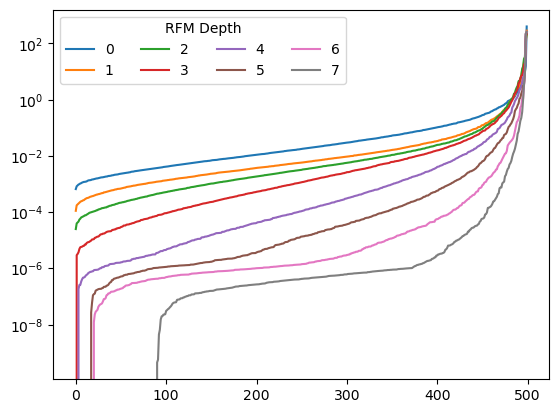

In [46]:
for dep in range(DEPTH):
    S2, _ = torch.linalg.eigh(XXs[dep].cuda())
    plt.semilogy(S2.cpu(), label=f'{dep}')
plt.legend(fontsize=10, ncols=4, title='RFM Depth')